# Import Libraries

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Import Data & Create Dataframe

In [2]:
path = '.\\data\\matches\\11'

In [3]:
def dir_path(path):
    if os.path.isdir(path):
        return path
    else:
        raise NotADirectoryError(path)

In [4]:
def json_list(path):
    try:
        path_to_json = dir_path(path)
        json_files = [json for json in os.listdir(path_to_json) if json.endswith('.json')]
        return json_files
    except:
        raise NotADirectoryError(path)
    

In [5]:
json_files = json_list(path)

## DATA USED:

A row of data was created for each game. The following data was considered most relevant for this exercise:

* 'home_team_id'

* 'home_team_name'

* 'manager_home_team'

* 'manager_home_id'

* 'away_team'

* 'away_team_id'

* 'manager_away_team'

* 'manager_away_id'

* 'referee_id'

* 'referee_name'

* 'home_score'

* 'away_score'

The following extra data column was added which shows whether the home team has won("YES"),lost ("NO"), or came equal ("EQUAL"):

* 'home_team_won?'

## DATA CLEANING:

On some games "managers" and "referee" data was missing. Instead of removing the whole data row, "None" was used instead.

In [6]:
df = pd.DataFrame(columns=['home_team_id', 'home_team_name','manager_home_team','manager_home_id','away_team','away_team_id','manager_away_team','manager_away_id','referee_id','referee_name','home_score','away_score','home_team_won?'])

In [7]:
for file in json_files:
    path_new = path + '\\' + file
    with open(path_new,'r',encoding= 'utf-8') as src:
        data = src.read()
        games = json.loads(data)
        for game in games:
            manager_id = (lambda x : 0 if (x==0) else x[0]['id'])
            manager_name = (lambda x : 0 if (x==0) else x[0]['name'])
            referee_id = (lambda x : 0 if (x==0) else x['id'])
            referee_name = (lambda x : 0 if (x==0) else x['name'])
            new_row = {'home_team_id': game['home_team']['home_team_id'],'home_team_name':game['home_team']['home_team_name'],'manager_home_team':manager_name(game.get('home_team',0).get('managers',0)),'manager_home_id':manager_id(game.get('home_team',0).get('managers',0)),'away_team':game['away_team']['away_team_name'],'away_team_id':game['away_team']['away_team_id'],'manager_away_team':manager_name(game.get('away_team',0).get('managers',0)),'manager_away_id':manager_id(game.get('away_team',0).get('managers',0)),'referee_id':referee_id(game.get('referee',0)),'referee_name':referee_name(game.get('referee',0)),'home_score':game['home_score'],'away_score':game['away_score']}
            df = df.append(new_row, ignore_index=True)

In [8]:
df['home_team_won?'] = np.where(df['away_score'] <df['home_score'], "YES", np.where(df['home_score'] <df['away_score'], 'NO', 'EQUAL'))

In [9]:
df.head(10)

,home_team_id,home_team_name,manager_home_team,manager_home_id,away_team,away_team_id,manager_away_team,manager_away_id,referee_id,referee_name,home_score,away_score,home_team_won?
0,217,Barcelona,Ernesto Valverde Tejedor,227,Espanyol,214,Enrique Sánchez Flores,236,183,Jesús Gil,5,0,YES
1,217,Barcelona,Ernesto Valverde Tejedor,227,Leganés,205,Asier Garitano Aguirrezábal,84,215,Ricardo De Burgos,3,1,YES
2,214,Espanyol,Enrique Sánchez Flores,236,Barcelona,217,Ernesto Valverde Tejedor,227,183,Jesús Gil,1,1,EQUAL
3,217,Barcelona,Ernesto Valverde Tejedor,227,Eibar,322,José Luis Mendilibar Etxebarria,221,208,Alejandro Hernández,6,1,YES
4,217,Barcelona,Ernesto Valverde Tejedor,227,Celta Vigo,209,Juan Carlos Unzué Labiano,208,209,Mario Melero,2,2,EQUAL
5,213,Sevilla,Vincenzo Montella,232,Barcelona,217,Ernesto Valverde Tejedor,227,211,José González,2,2,EQUAL
6,207,Valencia,Juan Rubén Uría Corral,507,Barcelona,217,Ernesto Valverde Tejedor,227,218,Ignacio Iglesias,1,1,EQUAL
7,217,Barcelona,Ernesto Valverde Tejedor,227,Getafe,216,José Bordalás Jiménez,228,222,David Fernández,0,0,EQUAL
8,222,Villarreal,Javier Calleja Revilla,182,Barcelona,217,Ernesto Valverde Tejedor,227,215,Ricardo De Burgos,0,2,NO
9,211,Girona,Pablo Javier Machín Díez,234,Barcelona,217,Ernesto Valverde Tejedor,227,220,José Sánchez,0,3,NO


# Summary Statistics

From the table below we can see that we have 485 observations in our La Liga data set e.g. 485 games played. 

There are 40 unique teams that played at their home stadium and 38 unique teams who played in away stadiums. The most common team in both common and away games is Barcelona. 

It is save to say to that our dataset in unbalanced because more than half of the games were played by Barcelona. To build a good predictive model we will need a balanced dataset were each team is equally represented on the sample, that will help so that the model will not learn to predict "Barcelona".

The manager who appeared in most games is Luis Enrique Martínez García, this is what we expected as he is the manager of Barcelona which is the team that played in most games. The most common referee is Alberto Undiano.

On interesting observation, as we can see from the last column on the table below, is that teams which play on their stadium usually win. Again though we need to be mindful that the data set is not balanced hence Barcelonas performance affects the statitistics. 

In [10]:
df.describe()

,home_team_id,home_team_name,manager_home_team,manager_home_id,away_team,away_team_id,manager_away_team,manager_away_id,referee_id,referee_name,home_score,away_score,home_team_won?
count,485,485,485,485,485,485,485,485,485,485,485,485,485
unique,40,40,75,75,38,38,75,75,50,50,9,9,3
top,217,Barcelona,0,0,Barcelona,217,0,0,221,Alberto Undiano,2,0,YES
freq,244,244,171,171,241,241,171,171,33,33,116,145,237


In terms of score, teams that have competed against another team in their home stadium achieved a minimum of zero and a maximum of 8 goals. On average the home teams have achieved 2 goals. 

Teams that have competed in away stadiums have achieved similar results in terms of min and max but on average have scored less e.g. 1.49 goals per game.

As we can observe on distribution histograms below, home teams are more frequently achieving 1 or 2 goals per game while away teams achieve more frequently zero or one goals per game. Both distributions are heavily skewed towards the right which means that it is uncommon for both home and away teams to achieve high scores, but this could happen.

In [11]:
df.agg({'home_score': ['min', 'max','mean'],'away_score': ['min', 'max','mean']})

,home_score,away_score
min,0.0,0.000000
max,8.0,8.000000
mean,2.0,1.490722


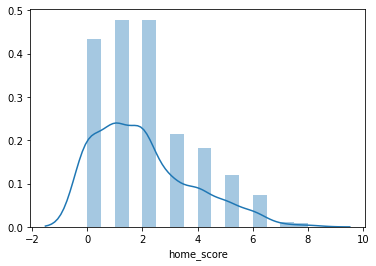

In [12]:
sns.distplot(df["home_score"]);

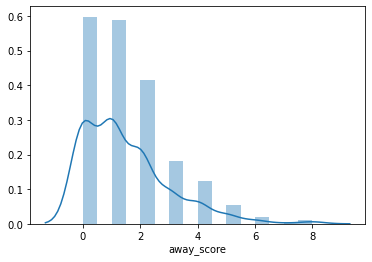

In [13]:
sns.distplot(df["away_score"]);

The following two plots are interesting as they show the number of games played by each home team and each away team. As we can see Barcelona dominates the sample as it has played both the most home and away games.

Text(0, 0.5, 'Frequency')

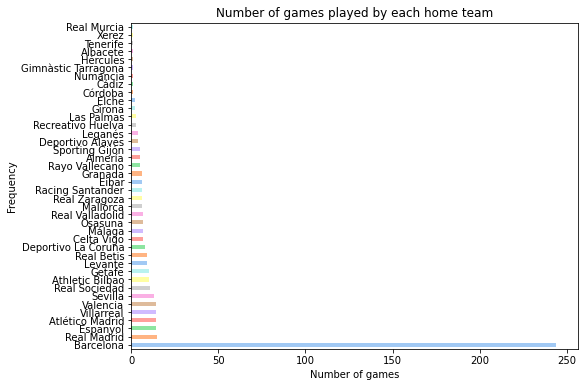

In [14]:
colors=sns.color_palette("pastel", 10)
pd.Series(df["home_team_name"]).value_counts().plot(kind = "barh",
                                    color=colors,figsize=(8,6),rot=0, title = "Number of games played by each home team")
plt.xlabel('Number of games', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

Text(0, 0.5, 'Frequency')

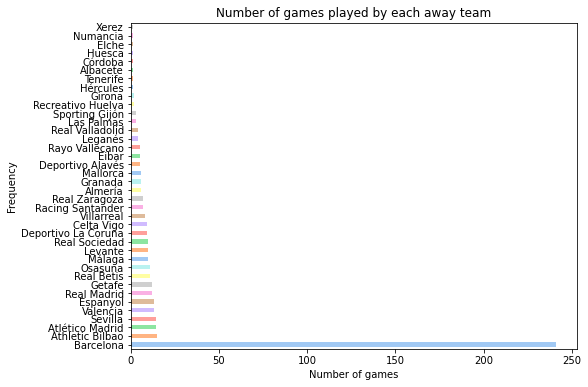

In [15]:
colors=sns.color_palette("pastel",10)
pd.Series(df["away_team"]).value_counts().plot(kind = "barh",
                                    color=colors,figsize=(8,6),rot=0, title = "Number of games played by each away team")
plt.xlabel('Number of games', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

But which home team has won the most home games? From the frequency word cloud below we can see that (if we exclude Barcelona) Madrid, Real and Real Sociedad win in their home games.

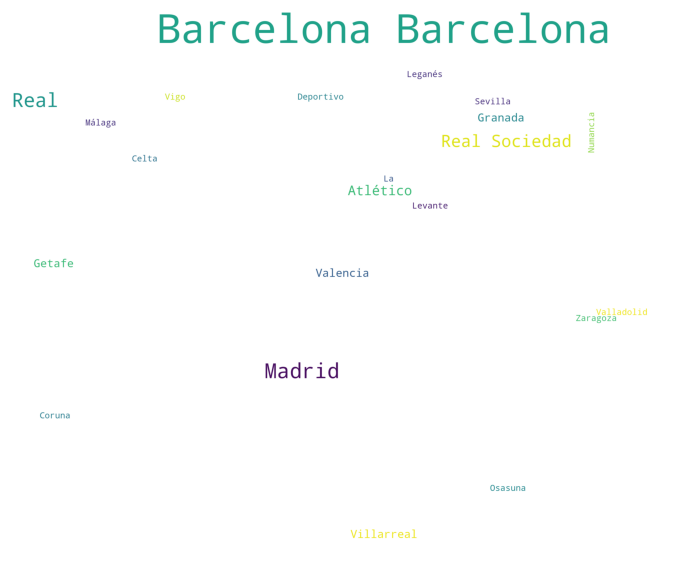

In [16]:
wc=df[df['home_team_won?']=='YES']
words = ' '.join(wc['home_team_name'])
cleaned_word = " ".join([word for word in words.split()])
wordcloud = WordCloud(
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The next question will be which team has lost in most home games? As we can see from the plot below, if we exclude Barcelona that dominates our sample, Real, Villarreal and Espanyol lost a lot of home games.

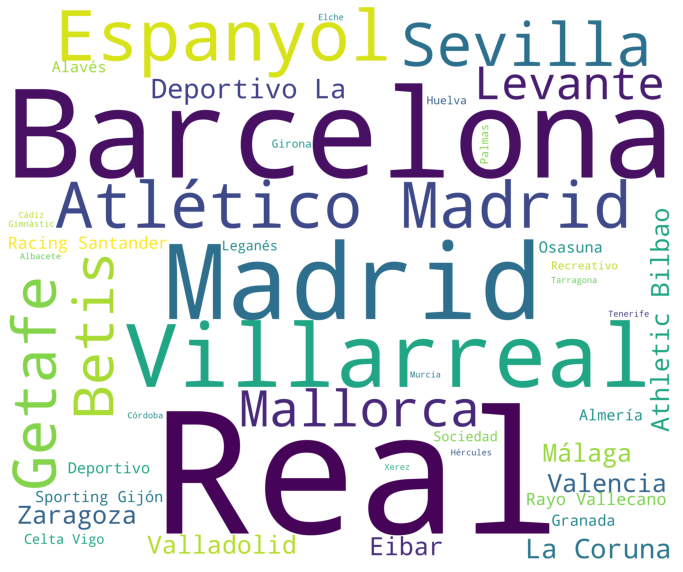

In [17]:
wc=df[df['home_team_won?']=='NO']
words = ' '.join(wc['home_team_name'])
cleaned_word = " ".join([word for word in words.split()])
wordcloud = WordCloud(
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Finally it will be interesting to see which teams are frequently wining in their away games. Excluding Barcelona, it is Madrid, Real and Valencia that are winning a lot of away games.

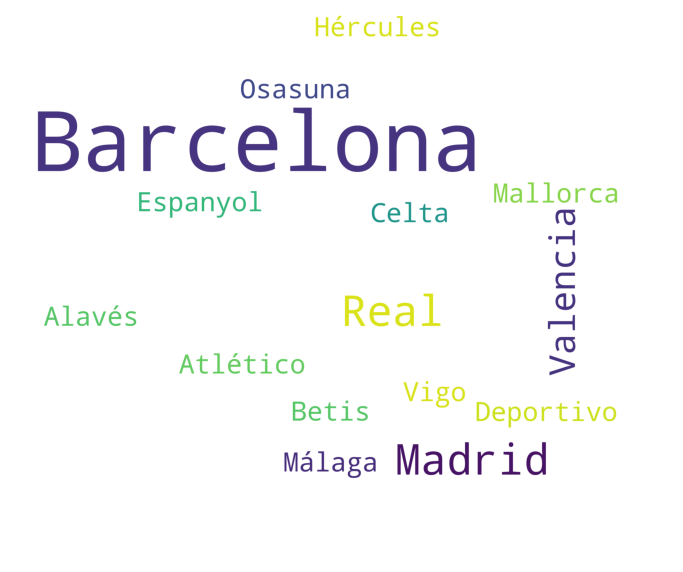

In [18]:
wc=df[df['home_team_won?']=='NO']
words = ' '.join(wc['away_team'])
cleaned_word = " ".join([word for word in words.split()])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Predictive Model

## Features

I decided to keep to use the following features to train my model:

* 'home_team_id'

* 'manager_home_id'

* 'away_team_id'

* 'manager_away_id'

* 'referee_id'



## TARGET CLASS

The target class is the following:

* 'home_team_won?'



## ENCODING

I used one hot encoding to encode the categorical features.



## MODELS

I experimented with the following models:

* DecisionTreeClassifier

* RandomForestClassifier

* MultinomialNB

* SVC

* KNeighborsClassifier



## RESULTS

SVC achieved 55% accuracy and DecisionTree a maximum of 65%. I chose to keep SVC because its accuracy is steady at 55% while accuracy for Decision tree fluctuates a lot. Considering that the model has to predict between 3 classes and the size of the dataset 55% is reasonable. Ideally, if I had more time I could balance out the data so that Barcelona does not dominate the sample.

In [19]:
df2 = df.copy()

In [20]:
df2 = df2.drop(['home_team_name', 'manager_home_team','away_team','manager_away_team','referee_name','home_score','away_score'], axis=1)

In [21]:
x = df2.drop(columns='home_team_won?')

In [22]:
y = df['home_team_won?'].copy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=0)

In [24]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [25]:
class MultiColumnLabelEncoder:
    
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode 
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''

        output = X.copy()

        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)

        return output  
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [26]:
le = MultiColumnLabelEncoder()
X_train_le = le.fit_transform(X_train)

In [27]:
X_train_ohe = ohe.fit_transform(X_train_le)

In [28]:
X_test_le = le.transform(X_test)
X_test_ohe = ohe.transform(X_test_le)

In [29]:
model = SVC()

In [30]:
model.fit(X_train_ohe, y_train)

SVC()

In [31]:
#accuracy
print(model.score(X_test_ohe,y_test)*100, '%')

55.10204081632652 %


# Working Model

After training the model we can predict the class of an  unseen example by doing the following:

* Encode the features e.g. home_team_id  --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

* Unite all the encoded features (Feature Union)

* Use the model.predict method to predict the outcome of the game

* All of the above can be included in a sklearn pipeline

Example:

In [32]:
print(model.predict([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

['NO']
